<a href="https://colab.research.google.com/github/vivek-VU21CSEN0100359/OIBSIP/blob/main/Project_3_D_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap optuna joblib xgboost

In [31]:
import os
for dirname, _, filenames in os.walk('/content/sample_data/creditcard.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import copy
import shap
import optuna
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from tabulate import tabulate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from optuna.samplers import TPESampler
from sklearn.metrics import precision_score, precision_recall_curve, average_precision_score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    brier_score_loss,
    confusion_matrix,
    average_precision_score,
)
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
creditcard = pd.read_csv('/content/sample_data/creditcard.csv')
print(f"Rows: {creditcard.shape[0]:,}")
print(f"Cols: {creditcard.shape[1]:,}")
creditcard.head(3)

Rows: 284,807
Cols: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [32]:
creditcard[['Time', 'Amount', 'Class']].dtypes

,0
Time,float64
Amount,float64
Class,int64


In [33]:
# ----------------------------- #
# Add some time-related columns #
# ----------------------------- #

creditcard['Time_Hours'] = creditcard['Time'] / 3_600
creditcard['Time_Days'] = creditcard['Time_Hours'] / 24
creditcard['Hour_of_Day'] = creditcard['Time'] % 86_400 / 3_600

# Encode as cyclic features which can help ML models understand cyclic nature of time.
creditcard['Hour_sin'] = np.sin(2 * np.pi * creditcard['Hour_of_Day'] / 24)
creditcard['Hour_cos'] = np.cos(2 * np.pi * creditcard['Hour_of_Day'] / 24)

creditcard[['Time', 'Time_Hours', 'Time_Days', 'Hour_of_Day', 'Hour_sin', 'Hour_cos']].head(5)

,Time,Time_Hours,Time_Days,Hour_of_Day,Hour_sin,Hour_cos
0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
1,86526.0,24.035000,1.001458,0.035000,0.009163,0.999958
2,86525.0,24.034722,1.001447,0.034722,0.009090,0.999959
3,86525.0,24.034722,1.001447,0.034722,0.009090,0.999959
4,86523.0,24.034167,1.001424,0.034167,0.008945,0.999960


In [34]:
# ------------------------------------------------- #
# Global Variables to use across the whole notebook #
# ------------------------------------------------- #

RANDOM_STATE = 42

TS = 'Time'
TARGET = 'Class'
MONEY = 'Amount'
LABELS = ['Genuine', 'Fraudulent']

In [35]:
def return_performance_statistics(model, X_tr, y_tr, X_te, y_te):
    results = {
        'train': {
            'accuracy': None,
            'precision': None,
            'recall': None,
            'auc_roc': None,
            'ap': None,
            'brier': None
        },
        'test': {
            'accuracy': None,
            'precision': None,
            'recall': None,
            'auc_roc': None,
            'ap': None,
            'brier': None
        },
    }

    # --------- #
    # TRAIN_VAL #
    # --------- #
    y_proba_train = model.predict_proba(X_tr)[:, 1]
    y_pred_train = model.predict(X_tr)

    results['train']['accuracy'] = accuracy_score(y_tr, y_pred_train)
    results['train']['precision'] = precision_score(y_tr, y_pred_train)
    results['train']['recall'] = recall_score(y_tr, y_pred_train)
    results['train']['auc_roc'] = roc_auc_score(y_tr, y_proba_train)
    results['train']['ap'] = average_precision_score(y_tr, y_proba_train)
    results['train']['brier'] = brier_score_loss(y_tr, y_proba_train)

    # ---- #
    # TEST #
    # ---- #

    y_proba_test = model.predict_proba(X_te)[:, 1]
    y_proba_test = pd.Series(y_proba_test, index=y_te.index)
    y_pred_test = model.predict(X_te)

    results['test']['accuracy'] = accuracy_score(y_te, y_pred_test)
    results['test']['precision'] = precision_score(y_te, y_pred_test)
    results['test']['recall'] = recall_score(y_te, y_pred_test)
    results['test']['auc_roc'] = roc_auc_score(y_te, y_proba_test)
    results['test']['ap'] = average_precision_score(y_te, y_proba_test)
    results['test']['brier'] = brier_score_loss(y_te, y_proba_test)

    return results

In [36]:
# --- Get basic statistics ---
pd.DataFrame(
    {
        'Data Type': creditcard.dtypes,
        'Missing Count (#)': creditcard.isnull().sum(),
        'Missing Rate (%)': 100 * creditcard.isnull().mean(),
        'Unique Count (#)': creditcard.nunique(),
        'Unique Rate (%)': round(100 * creditcard.nunique() / creditcard.shape[0], 2),
        'Duplicates Count (#)': [creditcard[c].duplicated().sum() for c in creditcard.columns],
        'Duplicates Rate (%)': [round(100 * creditcard[c].duplicated().sum() / creditcard.shape[0], 2) for c in creditcard.columns],
    }
)

,Data Type,Missing Count (#),Missing Rate (%),Unique Count (#),Unique Rate (%),Duplicates Count (#),Duplicates Rate (%)
Time,float64,0,0.0,124592,43.75,160215,56.25
V1,float64,0,0.0,275663,96.79,9144,3.21
V2,float64,0,0.0,275663,96.79,9144,3.21
V3,float64,0,0.0,275663,96.79,9144,3.21
V4,float64,0,0.0,275663,96.79,9144,3.21
V5,float64,0,0.0,275663,96.79,9144,3.21
V6,float64,0,0.0,275663,96.79,9144,3.21
V7,float64,0,0.0,275663,96.79,9144,3.21
V8,float64,0,0.0,275663,96.79,9144,3.21
V9,float64,0,0.0,275663,96.79,9144,3.21


In [37]:
# --- Understand overall fraud behavior ---
100*creditcard[TARGET].value_counts(normalize=True)

overall_fraud_count = creditcard[TARGET].sum()
overall_fraud_rate = overall_fraud_count / creditcard.shape[0]
non_fraud_count = creditcard.shape[0] - overall_fraud_count
overall_non_fraud_rate = non_fraud_count / creditcard.shape[0]

pd.DataFrame({
    'Metric': ['Number of Genuine', 'Number of Fraud', 'Genuine Rate (%)', 'Fraud Rate (%)'],
    'Value': [non_fraud_count, overall_fraud_count, 100*overall_non_fraud_rate, 100*overall_fraud_rate]
})

,Metric,Value
0,Number of Genuine,284315.000000
1,Number of Fraud,492.000000
2,Genuine Rate (%),99.827251
3,Fraud Rate (%),0.172749


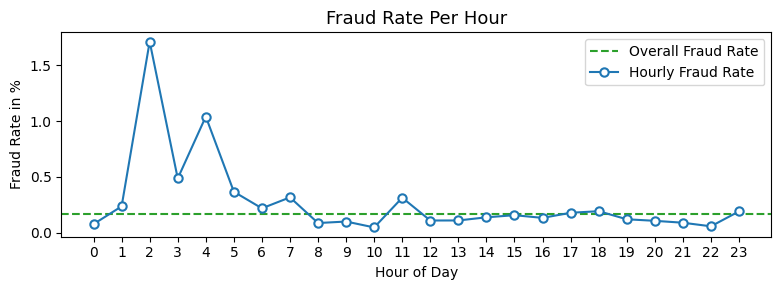

In [38]:
# --------- #
# Preparing #
# --------- #

creditcard['Hour'] = creditcard['Time'] // 3_600 % 24
hourly_fraud_rate = creditcard.groupby('Hour')['Class'].mean().reset_index()
overall_fraud_rate = creditcard['Class'].mean() * 100
hourly_fraud_rate['Class'] *= 100


# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(8, 3))
plt.axhline(y=overall_fraud_rate, color='C2', linestyle='--', label='Overall Fraud Rate')
plt.plot(hourly_fraud_rate['Hour'], hourly_fraud_rate['Class'],
         linestyle='-', marker='o', markerfacecolor='white', markeredgewidth=1.5, color='C0', label='Hourly Fraud Rate')
plt.title('Fraud Rate Per Hour', fontsize=13)
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate in %')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


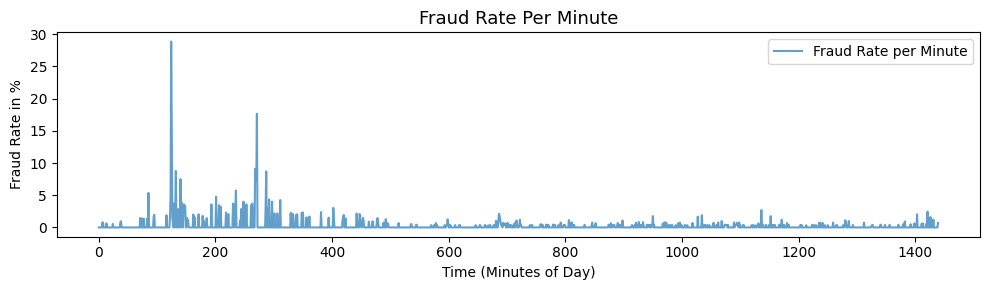

In [39]:
# --------- #
# Preparing #
# --------- #

creditcard['Minute'] = (creditcard['Time'] // 60) % 1440
minute_fraud_rate = creditcard.groupby('Minute')['Class'].mean().reset_index()
minute_fraud_rate['Class'] *= 100


# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(10, 3))

plt.plot(minute_fraud_rate['Minute'], minute_fraud_rate['Class'], linestyle='-', color='C0',
         label='Fraud Rate per Minute', alpha=0.7)
plt.title('Fraud Rate Per Minute', fontsize=13)
plt.xlabel('Time (Minutes of Day)')
plt.ylabel('Fraud Rate in %')
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.show()

<ipython-input-40-12a7581e7d12>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(LABELS)


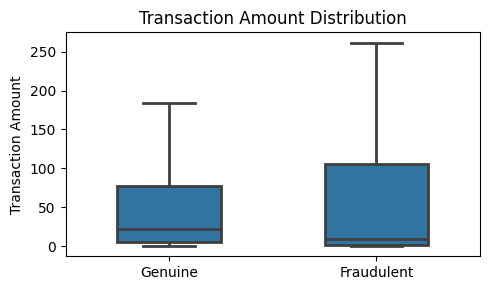

In [40]:
fig, axes = plt.subplots(figsize=(5, 3))

sns.boxplot(data=creditcard, x=TARGET, y=MONEY,
            linewidth=2, width=0.5, showfliers=False, ax=axes)
axes.set_title('Transaction Amount Distribution')
axes.set_xlabel('')
axes.set_ylabel('Transaction Amount')
axes.set_xticklabels(LABELS)

plt.tight_layout()
plt.show()

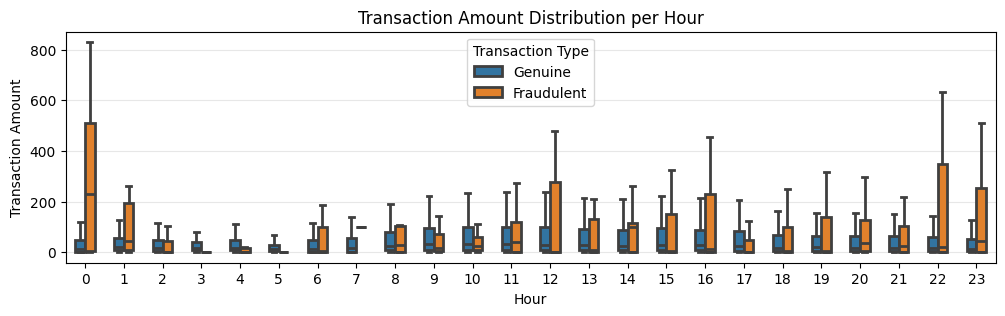

In [41]:
plt.figure(figsize=(12, 3))

sns.boxplot(data=creditcard, x='Hour', y=MONEY, hue=TARGET, linewidth=2, width=0.5, showfliers=False)
plt.title('Transaction Amount Distribution per Hour')
plt.xlabel('Hour')
plt.ylabel('Transaction Amount')

handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Genuine' if label == '0' else 'Fraudulent' for label in labels]
plt.legend(handles, labels, title='Transaction Type')

plt.xticks(ticks=plt.xticks()[0], labels=[int(x) for x in plt.xticks()[0]])
plt.grid(True, axis='y', alpha=0.3)

plt.show()

In [ ]:
creditcard.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,Amount,Class,Time_Hours,Time_Days,Hour_of_Day,Hour_sin,Hour_cos,Hour,Minute
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.021053,149.62,0,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.014724,2.69,0,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.059752,378.66,0,0.000278,0.000012,0.000278,0.000073,1.0,0.0,0.0


In [42]:
# ------------------------------- #
# Split dataset in TRAIN and TEST #
# ------------------------------- #

creditcard = creditcard.sort_values(by='Hour').reset_index(drop=True)

# Predict everything after the split_hour.
split_hour = 20

train = creditcard[creditcard['Hour'] <= split_hour]
test = creditcard[creditcard['Hour'] > split_hour]

N_train, N_test = train.shape[0], test.shape[0]
N_total = N_train + N_test
pct_train, pct_test = 100 * N_train / N_total, 100 * N_test / N_total
frauds_train, frauds_test = train[train['Class']==1].shape[0], test[test['Class']==1].shape[0]

print(f"""Statistics
==========
{4*' '}TRAIN
{8*' '}  Rows: {N_train:8,} ({pct_train:0.2f} %)
{8*' '}Frauds: {frauds_train:8,}  ({100*frauds_train/N_train:0.4f} %) = {100*frauds_train/(frauds_train+frauds_test):0.4f} % of all frauds
{4*' '}TEST
{8*' '}  Rows: {N_test:8,} ({pct_test:0.2f} %)
{8*' '}Frauds: {frauds_test:8,}  ({100*frauds_test/N_test:0.4f} %) = {100*frauds_test/(frauds_train+frauds_test):0.4f} % of all frauds
""")

Statistics
    TRAIN
          Rows:  240,725 (84.52 %)
        Frauds:      446  (0.1853 %) = 90.6504 % of all frauds
    TEST
          Rows:   44,082 (15.48 %)
        Frauds:       46  (0.1044 %) = 9.3496 % of all frauds



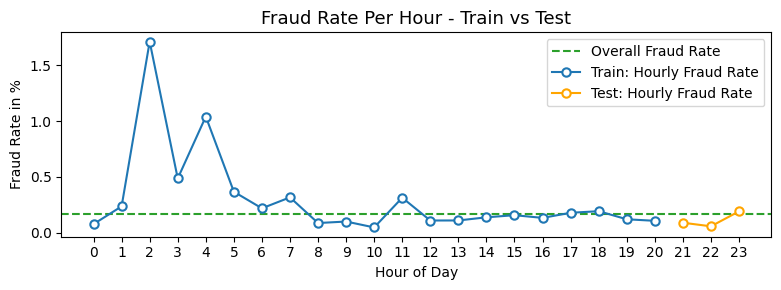

In [43]:
# --------- #
# Preparing #
# --------- #

overall_fraud_rate = creditcard['Class'].mean() * 100

hourly_fraud_rate_train = train.groupby('Hour')['Class'].mean().reset_index()
hourly_fraud_rate_test = test.groupby('Hour')['Class'].mean().reset_index()

hourly_fraud_rate_train['Class'] *= 100
hourly_fraud_rate_test['Class'] *= 100


# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(8, 3))

plt.axhline(y=overall_fraud_rate, color='C2', linestyle='--', label='Overall Fraud Rate')
plt.plot(hourly_fraud_rate_train['Hour'], hourly_fraud_rate_train['Class'],
         linestyle='-', marker='o', markerfacecolor='white', markeredgewidth=1.5, color='C0',
         label='Train: Hourly Fraud Rate')
plt.plot(hourly_fraud_rate_test['Hour'], hourly_fraud_rate_test['Class'],
         linestyle='-', marker='o', markerfacecolor='white', markeredgewidth=1.5, color='orange',
         label='Test: Hourly Fraud Rate')
plt.title('Fraud Rate Per Hour - Train vs Test', fontsize=13)
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate in %')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.show()

In [44]:
BASE_FEATURES = [
    'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
    'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
    MONEY
]

In [45]:
# --- Split datasets to train and predict on ---
X_train, y_train = train[BASE_FEATURES], train[TARGET]
X_test, y_test = test[BASE_FEATURES], test[TARGET]

In [46]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:10:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [47]:
results = return_performance_statistics(model, X_train, y_train, X_test, y_test)
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC ROC', 'AP', 'Brier'],
    'Train': [
        results.get('train').get('accuracy'),
        results.get('train').get('precision'),
        results.get('train').get('recall'),
        results.get('train').get('auc_roc'),
        results.get('train').get('ap'),
        results.get('train').get('brier'),
    ],
    'Test': [
        results.get('test').get('accuracy'),
        results.get('test').get('precision'),
        results.get('test').get('recall'),
        results.get('test').get('auc_roc'),
        results.get('test').get('ap'),
        results.get('test').get('brier'),
    ],
})
metrics_df

,Metric,Train,Test
0,Accuracy,1.000000,0.999614
1,Precision,1.000000,0.914286
2,Recall,1.000000,0.695652
3,AUC ROC,1.000000,0.956445
4,AP,1.000000,0.748251
5,Brier,0.000002,0.000357


In [48]:
LABELS = ['Genuine', 'Fraud']

cm = confusion_matrix(y_train, model.predict(X_train))
print(f"{' TRAINING ':=^50}")
print(tabulate(cm,
               headers=[f'Pred {l}' for l in LABELS],
               showindex=[f'True {l}' for l in LABELS],
               floatfmt=",.0f", tablefmt="simple_grid"))
print()

cm = confusion_matrix(y_test, model.predict(X_test))
print(f"{' TEST ':=^50}")
print(tabulate(cm,
               headers=[f'Pred {l}' for l in LABELS],
               showindex=[f'True {l}' for l in LABELS],
               floatfmt=",.0f", tablefmt="simple_grid"))

==================== TRAINING ====================
┌──────────────┬────────────────┬──────────────┐
│              │   Pred Genuine │   Pred Fraud │
├──────────────┼────────────────┼──────────────┤
│ True Genuine │        240,279 │            0 │
├──────────────┼────────────────┼──────────────┤
│ True Fraud   │              0 │          446 │
└──────────────┴────────────────┴──────────────┘

====================== TEST ======================
┌──────────────┬────────────────┬──────────────┐
│              │   Pred Genuine │   Pred Fraud │
├──────────────┼────────────────┼──────────────┤
│ True Genuine │         44,033 │            3 │
├──────────────┼────────────────┼──────────────┤
│ True Fraud   │             14 │           32 │
└──────────────┴────────────────┴──────────────┘


In [49]:
LABELS = ['Genuine', 'Fraud']
datasets = ['TRAINING', 'TEST']
data = [(y_train, X_train), (y_test, X_test)]

def calculate_monetary_impact(y_true, y_pred, amt):
    TP = amt[(y_true == 1) & (y_pred == 1)].sum()
    TN = amt[(y_true == 0) & (y_pred == 0)].sum()
    FP = amt[(y_true == 0) & (y_pred == 1)].sum()
    FN = amt[(y_true == 1) & (y_pred == 0)].sum()
    return TP, TN, FP, FN

results = []

for (y, X), dataset in zip(data, datasets):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    TP, TN, FP, FN = calculate_monetary_impact(y, y_pred, X[MONEY])
    results.append([dataset, cm[1, 1], cm[0, 0], cm[0, 1], cm[1, 0], TP, TN, FP, FN])

results_df = pd.DataFrame(results, columns=['Dataset', 'TP', 'TN', 'FP', 'FN', 'TP Amt', 'TN Amt', 'FP Amt', 'FN Amt'])
results_df

,Dataset,TP,TN,FP,FN,TP Amt,TN Amt,FP Amt,FN Amt
0,TRAINING,446,240279,0,0,54513.35,22006732.53,0.00,0.00
1,TEST,32,44033,3,14,4054.33,3069926.45,25803.06,1560.29


In [50]:
# Sample the data. Otherwise SHAP value calculation takes too long.
X_test_sampled = X_test.sample(frac=0.1, random_state=RANDOM_STATE, replace=False)

# Calculate SHAP values.
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_sampled)

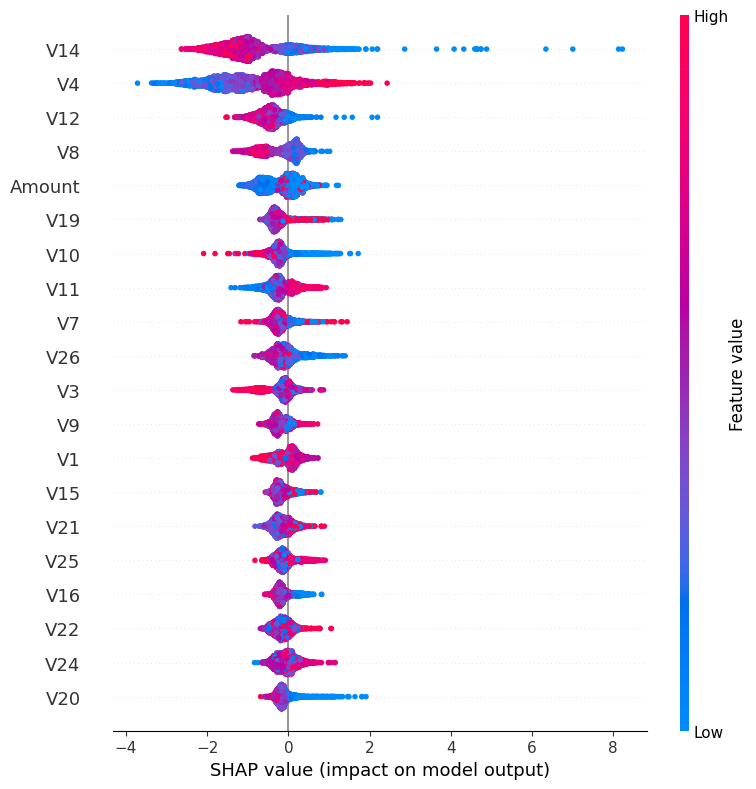

In [51]:
assert shap_values.shape[0] == X_test_sampled.shape[0], "ERROR: Mismatch in number of samples!"
assert shap_values.shape[1] == X_test_sampled.shape[1], "ERROR: Mismatch in number of features!"

# --- SHAP Summary Plot on Test Set Sample ---
shap.summary_plot(shap_values, X_test_sampled, plot_size=(8, 8))


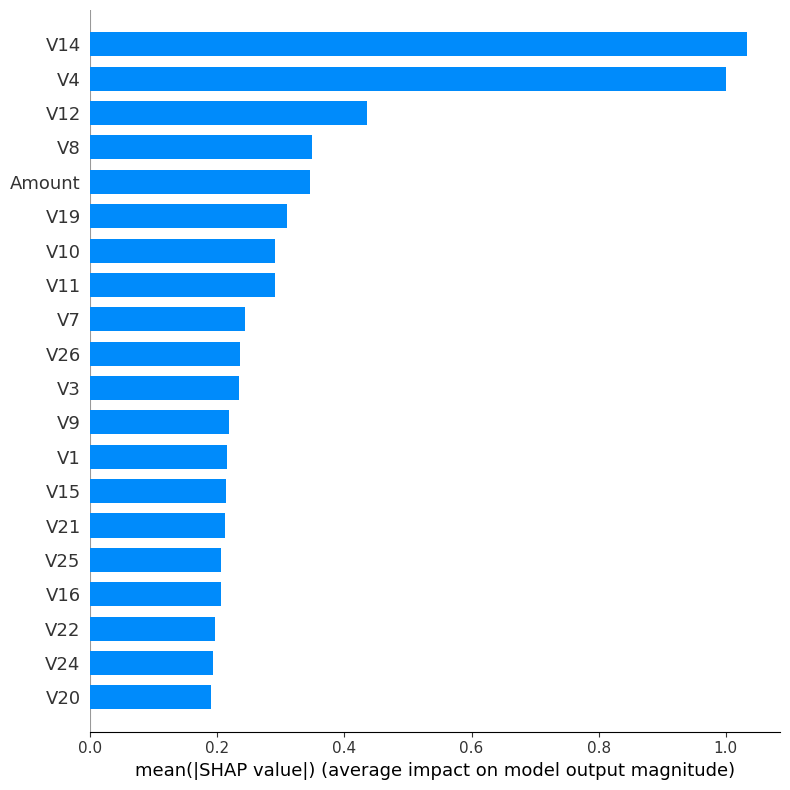

In [52]:
shap.summary_plot(shap_values, X_test_sampled, plot_type='bar', plot_size=(8, 8))

SHAP Waterfall plot for a Fraudulent (1) example
Predicted class: 0


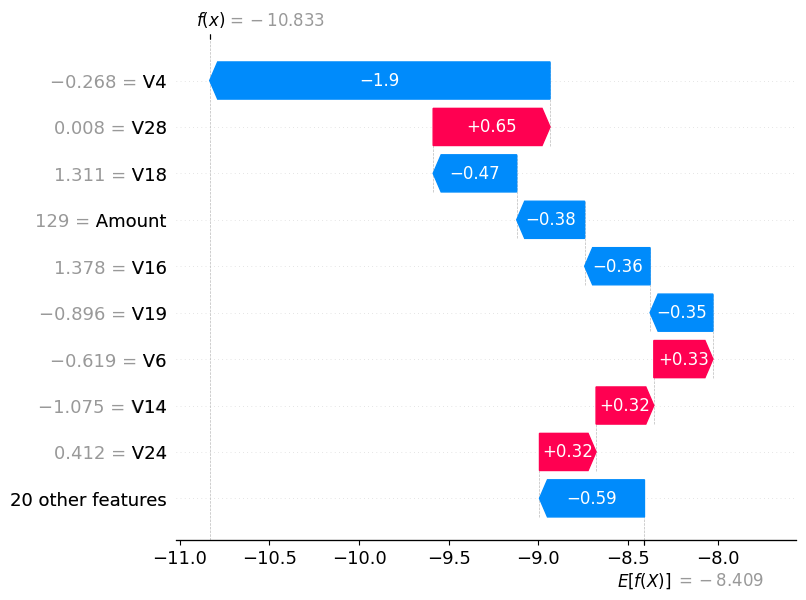

In [53]:
# --- Plot the SHAP values for a fraud example  ---

y_test_sampled = y_test.loc[X_test_sampled.index]
sampled_index = y_test_sampled[y_test_sampled == 1].sample(1, random_state=RANDOM_STATE).index[0]
predicted_class = model.predict([X_test_sampled.loc[sampled_index].values]).item()
instance_index = X_test_sampled.index.get_loc(sampled_index)

specific_shap_values = shap_values[instance_index, :]
specific_expected_value = explainer.expected_value

specific_explanation = shap.Explanation(values=specific_shap_values,
                                        base_values=specific_expected_value,
                                        data=X_test_sampled.iloc[instance_index],
                                        feature_names=X_test_sampled.columns)

print("SHAP Waterfall plot for a Fraudulent (1) example")
print(f"Predicted class: {predicted_class}")
shap.waterfall_plot(specific_explanation)

SHAP Waterfall plot for a Genuine (0) example
Predicted class: 0


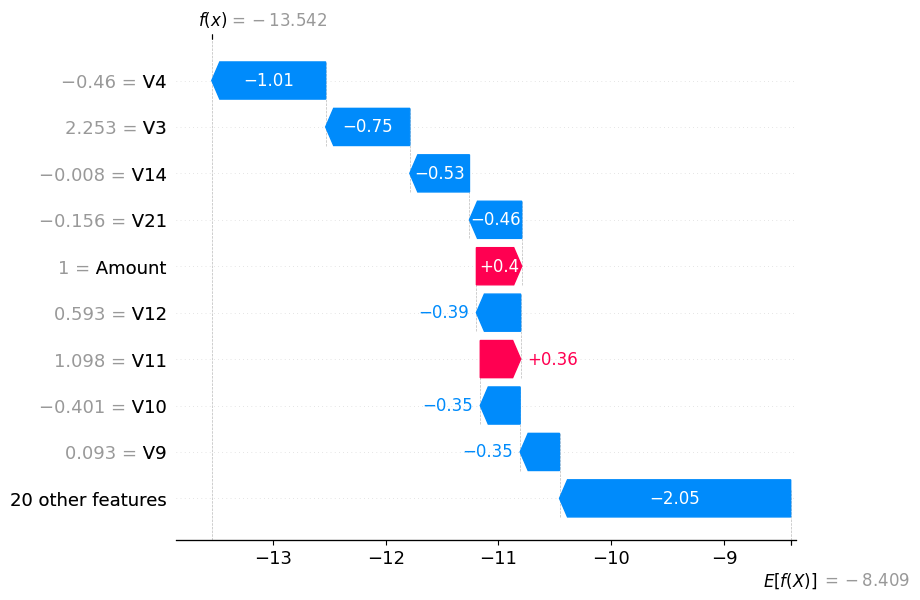

In [54]:
# --- Plot the SHAP values for a genuine example  ---

y_test_sampled = y_test.loc[X_test_sampled.index]
sampled_index = y_test_sampled[y_test_sampled == 0].sample(1, random_state=RANDOM_STATE).index[0]
predicted_class = model.predict([X_test_sampled.loc[sampled_index].values]).item()
instance_index = X_test_sampled.index.get_loc(sampled_index)

specific_shap_values = shap_values[instance_index, :]
specific_expected_value = explainer.expected_value

specific_explanation = shap.Explanation(values=specific_shap_values,
                                        base_values=specific_expected_value,
                                        data=X_test_sampled.iloc[instance_index],
                                        feature_names=X_test_sampled.columns)

print("SHAP Waterfall plot for a Genuine (0) example")
print(f"Predicted class: {predicted_class}")
shap.waterfall_plot(specific_explanation)

In [55]:
# --- To better understand for the reader what TSP is doing (compared to classical CV) ---

tscv = TimeSeriesSplit(n_splits=5)
timestamps = train.loc[X_train.index]['Hour']

split_num = 1
print("Hour time ranges for each TimeSeriesSplit")
print("=========================================")
for train_index, test_index in tscv.split(X_train):
    train_times = timestamps.iloc[train_index]
    test_times = timestamps.iloc[test_index]
    print(f"Split {split_num}:")
    print(f"  Train: {train_times.min():2.0f}  to  {train_times.max():2.0f}")
    print(f"  Test : {test_times.min():2.0f}  to  {test_times.max():.0f}")
    split_num += 1

Hour time ranges for each TimeSeriesSplit
Split 1:
  Train:  0  to   8
  Test :  8  to  11
Split 2:
  Train:  0  to  11
  Test : 11  to  13
Split 3:
  Train:  0  to  13
  Test : 13  to  16
Split 4:
  Train:  0  to  16
  Test : 16  to  18
Split 5:
  Train:  0  to  18
  Test : 18  to  20


In [56]:
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []

N_SPLITS = 5


# ----------------------------- #
# Define the objective function #
# ----------------------------- #

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "early_stopping_round": 10,
        'use_label_encoder': False,
        'verbosity': 0,
        # --- for overfitting ---
        'max_depth': trial.suggest_int('max_depth', 1, 16),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        # --- less sensitive to noise ---
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
    }

    tsp = TimeSeriesSplit(n_splits=N_SPLITS).split(X_train)

    train_precision_scores = []
    val_precision_scores = []
    train_recall_scores = []
    val_recall_scores = []

    for train_index, val_index in tsp:
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model = xgb.XGBClassifier(**params, random_state=RANDOM_STATE, n_jobs=-1)
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  verbose=False)

        y_train_pred = model.predict(X_train_fold)
        y_val_pred = model.predict(X_val_fold)

        train_precision = precision_score(y_train_fold, y_train_pred)
        val_precision = precision_score(y_val_fold, y_val_pred)
        train_recall = recall_score(y_train_fold, y_train_pred)
        val_recall = recall_score(y_val_fold, y_val_pred)
#         print(f"Train Precision: {train_precision:.2f}  Val Precision: {val_precision:.2f}")

        train_precision_scores.append(train_precision)
        val_precision_scores.append(val_precision)
        train_recall_scores.append(train_recall)
        val_recall_scores.append(val_recall)

    train_precisions.append(np.mean(train_precision_scores))
    val_precisions.append(np.mean(val_precision_scores))
    train_recalls.append(np.mean(train_recall_scores))
    val_recalls.append(np.mean(val_recall_scores))

    mu_train_precisions = np.mean(train_precisions)
    sd_train_precision = np.std(train_precisions)
    mu_val_precisions = np.mean(val_precision_scores)
    sd_val_precisions = np.std(val_precision_scores)

#     print(f"Train Precision: {mu_train_precisions:.2f} += {sd_train_precision:.2f}  |  Validation Precision: {mu_val_precisions:.2f} += {sd_val_precisions:.2f}")

    return np.mean(val_precision_scores)


# --------------------------------- #
# Run Bayesian Hyperparametertuning #
# --------------------------------- #

N_TRIALS = 100  # Number of Bayesian trials.

study = optuna.create_study(study_name='v2',
                            direction='maximize',
                            sampler=TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=N_TRIALS)

print(f"Best hyperparameters: {study.best_params}")

[I 2024-08-27 12:11:26,067] A new study created in memory with name: v2
[I 2024-08-27 12:11:54,946] Trial 0 finished with value: 0.9619157519467118 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'gamma': 0.7319939418114051, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309}. Best is trial 0 with value: 0.9619157519467118.
[I 2024-08-27 12:12:21,985] Trial 1 finished with value: 0.9449705798990987 and parameters: {'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.8661761457749352, 'subsample': 0.8803345035229626, 'colsample_bytree': 0.9124217733388136}. Best is trial 0 with value: 0.9619157519467118.
[I 2024-08-27 12:12:42,690] Trial 2 finished with value: 0.9642150993214822 and parameters: {'max_depth': 1, 'min_child_weight': 10, 'gamma': 0.8324426408004217, 'subsample': 0.7637017332034828, 'colsample_bytree': 0.7545474901621302}. Best is trial 2 with value: 0.9642150993214822.
[I 2024-08-27 12:13:08,867] Trial 3 finished with value: 0.9388378941320118 a

Best hyperparameters: {'max_depth': 1, 'min_child_weight': 7, 'gamma': 0.8756409951046862, 'subsample': 0.9121404133566402, 'colsample_bytree': 0.8409386893811229}


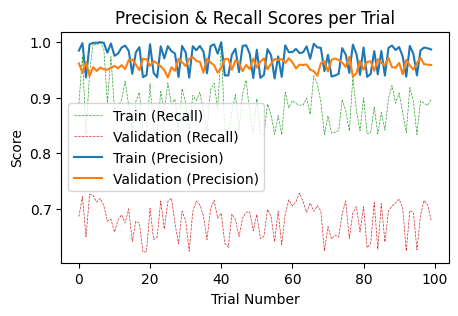

In [57]:
plt.figure(figsize=(5, 3))

plt.plot(np.arange(N_TRIALS), train_recalls, color='C2', linestyle='--', lw=0.5, label='Train (Recall)');
plt.plot(np.arange(N_TRIALS), val_recalls, color='C3', linestyle='--', lw=0.5, label='Validation (Recall)');
plt.plot(np.arange(N_TRIALS), train_precisions, color='C0', label='Train (Precision)');
plt.plot(np.arange(N_TRIALS), val_precisions, color='C1', label='Validation (Precision)');
plt.xlabel('Trial Number');
plt.ylabel('Score');
plt.title('Precision & Recall Scores per Trial');
plt.legend();

plt.show()

In [58]:
# --- Train the final model with the best hyperparameters on the whole train set ---

best_params = study.best_params
model = xgb.XGBClassifier(**best_params, early_stopping_round=10, eval_metric='logloss')
model.fit(X_train, y_train, verbose=0)

joblib.dump(model, 'model_v2.pkl')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:54:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)


['model_v2.pkl']

In [59]:
# --- Print the performance metrics ---

loaded_model = joblib.load('model_v2.pkl')
results = return_performance_statistics(loaded_model, X_train, y_train, X_test, y_test)
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC ROC', 'AP', 'Brier'],
    'Train': [
        results.get('train').get('accuracy'),
        results.get('train').get('precision'),
        results.get('train').get('recall'),
        results.get('train').get('auc_roc'),
        results.get('train').get('ap'),
        results.get('train').get('brier'),
    ],
    'Test': [
        results.get('test').get('accuracy'),
        results.get('test').get('precision'),
        results.get('test').get('recall'),
        results.get('test').get('auc_roc'),
        results.get('test').get('ap'),
        results.get('test').get('brier'),
    ],
})
metrics_df

,Metric,Train,Test
0,Accuracy,0.999489,0.999524
1,Precision,0.915167,0.878788
2,Recall,0.798206,0.630435
3,AUC ROC,0.990689,0.976335
4,AP,0.865262,0.707781
5,Brier,0.000438,0.000425


In [60]:
# --- Print the confusion matrices ---

cm = confusion_matrix(y_train, loaded_model.predict(X_train))
print(f"{' TRAINING ':=^50}")
print(tabulate(cm,
               headers=[f'Pred {l}' for l in LABELS],
               showindex=[f'True {l}' for l in LABELS],
               floatfmt=",.0f", tablefmt="simple_grid"))
print()

cm = confusion_matrix(y_test, loaded_model.predict(X_test))
print(f"{' TEST ':=^50}")
print(tabulate(cm,
               headers=[f'Pred {l}' for l in LABELS],
               showindex=[f'True {l}' for l in LABELS],
               floatfmt=",.0f", tablefmt="simple_grid"))

==================== TRAINING ====================
┌──────────────┬────────────────┬──────────────┐
│              │   Pred Genuine │   Pred Fraud │
├──────────────┼────────────────┼──────────────┤
│ True Genuine │        240,246 │           33 │
├──────────────┼────────────────┼──────────────┤
│ True Fraud   │             90 │          356 │
└──────────────┴────────────────┴──────────────┘

====================== TEST ======================
┌──────────────┬────────────────┬──────────────┐
│              │   Pred Genuine │   Pred Fraud │
├──────────────┼────────────────┼──────────────┤
│ True Genuine │         44,032 │            4 │
├──────────────┼────────────────┼──────────────┤
│ True Fraud   │             17 │           29 │
└──────────────┴────────────────┴──────────────┘


In [61]:
LABELS = ['Genuine', 'Fraud']
datasets = ['TRAINING', 'TEST']
data = [(y_train, X_train), (y_test, X_test)]

def calculate_monetary_impact(y_true, y_pred, amt):
    TP = amt[(y_true == 1) & (y_pred == 1)].sum()
    TN = amt[(y_true == 0) & (y_pred == 0)].sum()
    FP = amt[(y_true == 0) & (y_pred == 1)].sum()
    FN = amt[(y_true == 1) & (y_pred == 0)].sum()
    return TP, TN, FP, FN

results = []

for (y, X), dataset in zip(data, datasets):
    y_pred = loaded_model.predict(X)
    cm = confusion_matrix(y, y_pred)
    TP, TN, FP, FN = calculate_monetary_impact(y, y_pred, X[MONEY])
    results.append([dataset, cm[1, 1], cm[0, 0], cm[0, 1], cm[1, 0], TP, TN, FP, FN])

results_df = pd.DataFrame(results, columns=['Dataset', 'TP', 'TN', 'FP', 'FN', 'TP Amt', 'TN Amt', 'FP Amt', 'FN Amt'])
results_df

,Dataset,TP,TN,FP,FN,TP Amt,TN Amt,FP Amt,FN Amt
0,TRAINING,356,240246,33,90,39880.85,22004331.80,2400.73,14632.50
1,TEST,29,44032,4,17,4044.76,3069925.68,25803.83,1569.86


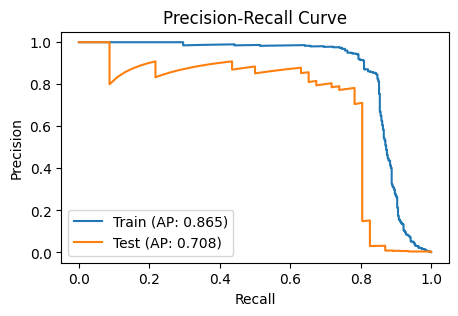

In [62]:
precision_recall_data = {
    'Train': [],
    'Test': []
}

# --- Plot precision recall curve ---
for dataset, (y, X) in zip(['Train', 'Test'], [(y_train, X_train), (y_test, X_test)]):
    y_pred = loaded_model.predict_proba(X)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_pred)
    precision_recall_data[dataset] = {
        'precision': precision,
        'recall': recall,
        'ap': average_precision_score(y, y_pred)
    }
ap_train = precision_recall_data['Train']['ap']
ap_test = precision_recall_data['Test']['ap']

plt.figure(figsize=(5, 3))
plt.plot(precision_recall_data['Train']['recall'], precision_recall_data['Train']['precision'], color='C0', label=f'Train (AP: {ap_train:.3f})');
plt.plot(precision_recall_data['Test']['recall'], precision_recall_data['Test']['precision'], color='C1', label=f'Test (AP: {ap_test:.3f})');
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('Precision-Recall Curve');
plt.legend();
plt.show()

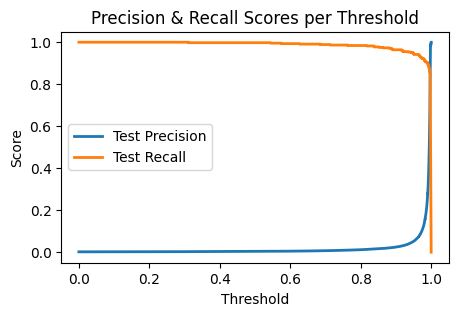

In [63]:
# --- Plot the precision and recall for different thresholds ---
thresholds = np.linspace(0, 1, len(precision_recall_data['Train']['recall']))

plt.figure(figsize=(5, 3))
plt.plot(thresholds, precision_recall_data['Train']['precision'], color='C0', lw=2, label='Test Precision');
plt.plot(thresholds, precision_recall_data['Train']['recall'], color='C1', lw=2, label='Test Recall');
plt.xlabel('Threshold');
plt.ylabel('Score');
plt.title('Precision & Recall Scores per Threshold');
plt.legend();
plt.show()